In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import json
import random
import pprint
import sys
import time
import numpy as np
from optparse import OptionParser
import pickle
import math
import cv2
import copy
from matplotlib import pyplot as plt
import tensorflow as tf
import pandas as pd
import os

from sklearn.metrics import average_precision_score

from keras import backend as K
from keras.optimizers import Adam, SGD, RMSprop
from keras.layers import Flatten, Dense, Input, Conv2D, MaxPooling2D, Dropout, Add, Activation, ZeroPadding2D, Convolution2D
from keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D, TimeDistributed, AveragePooling2D
from keras.engine.topology import get_source_inputs
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.objectives import categorical_crossentropy

from keras.models import Model
from keras.utils import generic_utils
from keras.engine import Layer, InputSpec
from keras import initializers, regularizers

class Config:

	def __init__(self):

		self.verbose = True
		self.network = 'vgg'
		self.use_horizontal_flips = False
		self.use_vertical_flips = False
		self.rot_90 = False

		self.anchor_box_scales = [64, 128, 256, 512] 

		#self.anchor_box_ratios = [[1, 1], [1./math.sqrt(2), 2./math.sqrt(2)], [2./math.sqrt(2), 1./math.sqrt(2)]]
		self.anchor_box_ratios = [[1, 1], [1, 2], [2, 1]]
		
		self.im_size = 600
		self.img_channel_mean = [103.939, 116.779, 123.68]
		self.img_scaling_factor = 1.0
		self.num_rois = 4
		self.rpn_stride = 16

		self.balanced_classes = False

		self.std_scaling = 4.0
		self.classifier_regr_std = [8.0, 8.0, 4.0, 4.0]

		self.rpn_min_overlap = 0.3
		self.rpn_max_overlap = 0.7

		self.classifier_min_overlap = 0.1
		self.classifier_max_overlap = 0.5
		self.class_mapping = None

		self.model_path = None

def union(au, bu, area_intersection):
	area_a = (au[2] - au[0]) * (au[3] - au[1])
	area_b = (bu[2] - bu[0]) * (bu[3] - bu[1])
	area_union = area_a + area_b - area_intersection
	return area_union


def intersection(ai, bi):
	x = max(ai[0], bi[0])
	y = max(ai[1], bi[1])
	w = min(ai[2], bi[2]) - x
	h = min(ai[3], bi[3]) - y
	if w < 0 or h < 0:
		return 0
	return w*h


def iou(a, b):

	if a[0] >= a[2] or a[1] >= a[3] or b[0] >= b[2] or b[1] >= b[3]:
		return 0.0

	area_i = intersection(a, b)
	area_u = union(a, b, area_i)

	return float(area_i) / float(area_u + 1e-6)

def get_new_img_size(width, height, img_min_side=600):
	if width <= height:
		f = float(img_min_side) / width
		resized_height = int(f * height)
		resized_width = img_min_side
	else:
		f = float(img_min_side) / height
		resized_width = int(f * width)
		resized_height = img_min_side

	return resized_width, resized_height

def non_max_suppression_fast(boxes, probs, overlap_thresh=0.9, max_boxes=300):
    if len(boxes) == 0:
        return []

    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]

    np.testing.assert_array_less(x1, x2)
    np.testing.assert_array_less(y1, y2)

    if boxes.dtype.kind == "i":
        boxes = boxes.astype("float")
    pick = []
    area = (x2 - x1) * (y2 - y1)
    idxs = np.argsort(probs)
    while len(idxs) > 0:
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)
        xx1_int = np.maximum(x1[i], x1[idxs[:last]])
        yy1_int = np.maximum(y1[i], y1[idxs[:last]])
        xx2_int = np.minimum(x2[i], x2[idxs[:last]])
        yy2_int = np.minimum(y2[i], y2[idxs[:last]])

        ww_int = np.maximum(0, xx2_int - xx1_int)
        hh_int = np.maximum(0, yy2_int - yy1_int)

        area_int = ww_int * hh_int
        area_union = area[i] + area[idxs[:last]] - area_int

        overlap = area_int/(area_union + 1e-6)
        idxs = np.delete(idxs, np.concatenate(([last],
            np.where(overlap > overlap_thresh)[0])))

        if len(pick) >= max_boxes:
            break

    boxes = boxes[pick].astype("int")
    probs = probs[pick]
    return boxes, probs

def apply_regr_np(X, T):
	try:
		x = X[0, :, :]
		y = X[1, :, :]
		w = X[2, :, :]
		h = X[3, :, :]

		tx = T[0, :, :]
		ty = T[1, :, :]
		tw = T[2, :, :]
		th = T[3, :, :]

		cx = x + w/2.
		cy = y + h/2.
		cx1 = tx * w + cx
		cy1 = ty * h + cy

		w1 = np.exp(tw.astype(np.float64)) * w
		h1 = np.exp(th.astype(np.float64)) * h
		x1 = cx1 - w1/2.
		y1 = cy1 - h1/2.

		x1 = np.round(x1)
		y1 = np.round(y1)
		w1 = np.round(w1)
		h1 = np.round(h1)
		return np.stack([x1, y1, w1, h1])
	except Exception as e:
		print(e)
		return X
    
def apply_regr(x, y, w, h, tx, ty, tw, th):
	try:
		cx = x + w/2.
		cy = y + h/2.
		cx1 = tx * w + cx
		cy1 = ty * h + cy
		w1 = math.exp(tw) * w
		h1 = math.exp(th) * h
		x1 = cx1 - w1/2.
		y1 = cy1 - h1/2.
		x1 = int(round(x1))
		y1 = int(round(y1))
		w1 = int(round(w1))
		h1 = int(round(h1))

		return x1, y1, w1, h1

	except ValueError:
		return x, y, w, h
	except OverflowError:
		return x, y, w, h
	except Exception as e:
		print(e)
		return x, y, w, h

def rpn_to_roi(rpn_layer, regr_layer, C, dim_ordering, use_regr=True, max_boxes=300,overlap_thresh=0.9):

	regr_layer = regr_layer / C.std_scaling

	anchor_sizes = C.anchor_box_scales   # (3 in here)
	anchor_ratios = C.anchor_box_ratios  # (3 in here)

	assert rpn_layer.shape[0] == 1

	(rows, cols) = rpn_layer.shape[1:3]

	curr_layer = 0

	A = np.zeros((4, rpn_layer.shape[1], rpn_layer.shape[2], rpn_layer.shape[3]))

	for anchor_size in anchor_sizes:
		for anchor_ratio in anchor_ratios:
			anchor_x = (anchor_size * anchor_ratio[0])/C.rpn_stride
			anchor_y = (anchor_size * anchor_ratio[1])/C.rpn_stride

			regr = regr_layer[0, :, :, 4 * curr_layer:4 * curr_layer + 4] 
			regr = np.transpose(regr, (2, 0, 1)) # shape => (4, 18, 25)
            
			X, Y = np.meshgrid(np.arange(cols),np. arange(rows))
			A[0, :, :, curr_layer] = X - anchor_x/2 
			A[1, :, :, curr_layer] = Y - anchor_y/2 
			A[2, :, :, curr_layer] = anchor_x      
			A[3, :, :, curr_layer] = anchor_y       
			
			if use_regr:
				A[:, :, :, curr_layer] = apply_regr_np(A[:, :, :, curr_layer], regr)

			
			A[2, :, :, curr_layer] = np.maximum(1, A[2, :, :, curr_layer])
			A[3, :, :, curr_layer] = np.maximum(1, A[3, :, :, curr_layer])

			
			A[2, :, :, curr_layer] += A[0, :, :, curr_layer]
			A[3, :, :, curr_layer] += A[1, :, :, curr_layer]

			
			A[0, :, :, curr_layer] = np.maximum(0, A[0, :, :, curr_layer])
			A[1, :, :, curr_layer] = np.maximum(0, A[1, :, :, curr_layer])
			A[2, :, :, curr_layer] = np.minimum(cols-1, A[2, :, :, curr_layer])
			A[3, :, :, curr_layer] = np.minimum(rows-1, A[3, :, :, curr_layer])

			curr_layer += 1

	all_boxes = np.reshape(A.transpose((0, 3, 1, 2)), (4, -1)).transpose((1, 0))  
	all_probs = rpn_layer.transpose((0, 3, 1, 2)).reshape((-1))                  

	x1 = all_boxes[:, 0]
	y1 = all_boxes[:, 1]
	x2 = all_boxes[:, 2]
	y2 = all_boxes[:, 3]

	
	idxs = np.where((x1 - x2 >= 0) | (y1 - y2 >= 0))

	all_boxes = np.delete(all_boxes, idxs, 0)
	all_probs = np.delete(all_probs, idxs, 0)

	result = non_max_suppression_fast(all_boxes, all_probs, overlap_thresh=overlap_thresh, max_boxes=max_boxes)[0]

	return result

def format_img_size(img, C):
	img_min_side = float(C.im_size)
	(height,width,_) = img.shape
		
	if width <= height:
		ratio = img_min_side/width
		new_height = int(ratio * height)
		new_width = int(img_min_side)
	else:
		ratio = img_min_side/height
		new_width = int(ratio * width)
		new_height = int(img_min_side)
	img = cv2.resize(img, (new_width, new_height), interpolation=cv2.INTER_CUBIC)
	return img, ratio	

def format_img_channels(img, C):
	
	img = img.astype(np.float32)
	img[:, :, 0] -= C.img_channel_mean[0]
	img[:, :, 1] -= C.img_channel_mean[1]
	img[:, :, 2] -= C.img_channel_mean[2]
	img /= C.img_scaling_factor
	img = np.transpose(img, (2, 0, 1))
	img = np.expand_dims(img, axis=0)
	return img

def format_img(img, C):
	img, ratio = format_img_size(img, C)
	img = format_img_channels(img, C)
	return img, ratio

def get_real_coordinates(ratio, x1, y1, x2, y2):

	real_x1 = int(round(x1 // ratio))
	real_y1 = int(round(y1 // ratio))
	real_x2 = int(round(x2 // ratio))
	real_y2 = int(round(y2 // ratio))

	return (real_x1, real_y1, real_x2 ,real_y2)

Using TensorFlow backend.


In [3]:
class RoiPoolingConv(Layer):
    
    def __init__(self, pool_size, num_rois, **kwargs):
        self.pool_size = pool_size
        self.num_rois = num_rois

        super(RoiPoolingConv, self).__init__(**kwargs)

    def build(self, input_shape):
        self.nb_channels = input_shape[0][3]   

    def compute_output_shape(self, input_shape):
        return None, self.num_rois, self.pool_size, self.pool_size, self.nb_channels

    def call(self, x, mask=None):

        assert(len(x) == 2)
        img = x[0]
        rois = x[1]
        input_shape = K.shape(img)
        outputs = []

        for roi_idx in range(self.num_rois):

            x = rois[0, roi_idx, 0]
            y = rois[0, roi_idx, 1]
            w = rois[0, roi_idx, 2]
            h = rois[0, roi_idx, 3]

            x = K.cast(x, 'int32')
            y = K.cast(y, 'int32')
            w = K.cast(w, 'int32')
            h = K.cast(h, 'int32')

            rs = tf.image.resize(img[:, y:y+h, x:x+w, :], (self.pool_size, self.pool_size))
            outputs.append(rs)
                

        final_output = K.concatenate(outputs, axis=0)
        final_output = K.reshape(final_output, (1, self.num_rois, self.pool_size, self.pool_size, self.nb_channels))
        final_output = K.permute_dimensions(final_output, (0, 1, 2, 3, 4))

        return final_output
    
    
    def get_config(self):
        config = {'pool_size': self.pool_size,
                  'num_rois': self.num_rois}
        base_config = super(RoiPoolingConv, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

class FixedBatchNormalization(Layer):

	def __init__(self, epsilon=1e-3, axis=-1,
				 weights=None, beta_init='zero', gamma_init='one',
				 gamma_regularizer=None, beta_regularizer=None, **kwargs):

		self.supports_masking = True
		self.beta_init = initializers.get(beta_init)
		self.gamma_init = initializers.get(gamma_init)
		self.epsilon = epsilon
		self.axis = axis
		self.gamma_regularizer = regularizers.get(gamma_regularizer)
		self.beta_regularizer = regularizers.get(beta_regularizer)
		self.initial_weights = weights
		super(FixedBatchNormalization, self).__init__(**kwargs)

	def build(self, input_shape):
		self.input_spec = [InputSpec(shape=input_shape)]
		shape = (input_shape[self.axis],)

		self.gamma = self.add_weight(shape = shape,
									 initializer=self.gamma_init,
									 regularizer=self.gamma_regularizer,
									 name='{}_gamma'.format(self.name),
									 trainable=False)
		self.beta = self.add_weight(shape = shape,
									initializer=self.beta_init,
									regularizer=self.beta_regularizer,
									name='{}_beta'.format(self.name),
									trainable=False)
		self.running_mean = self.add_weight(shape = shape, initializer='zero',
											name='{}_running_mean'.format(self.name),
											trainable=False)
		self.running_std = self.add_weight(shape = shape, initializer='one',
										   name='{}_running_std'.format(self.name),
										   trainable=False)

		if self.initial_weights is not None:
			self.set_weights(self.initial_weights)
			del self.initial_weights

		self.built = True

	def call(self, x, mask=None):

		assert self.built, 'Layer must be built before being called'
		input_shape = K.int_shape(x)

		reduction_axes = list(range(len(input_shape)))
		del reduction_axes[self.axis]
		broadcast_shape = [1] * len(input_shape)
		broadcast_shape[self.axis] = input_shape[self.axis]

		if sorted(reduction_axes) == range(K.ndim(x))[:-1]:
			x_normed = K.batch_normalization(
				x, self.running_mean, self.running_std,
				self.beta, self.gamma,
				epsilon=self.epsilon)
		else:
			broadcast_running_mean = K.reshape(self.running_mean, broadcast_shape)
			broadcast_running_std = K.reshape(self.running_std, broadcast_shape)
			broadcast_beta = K.reshape(self.beta, broadcast_shape)
			broadcast_gamma = K.reshape(self.gamma, broadcast_shape)
			x_normed = K.batch_normalization(
				x, broadcast_running_mean, broadcast_running_std,
				broadcast_beta, broadcast_gamma,
				epsilon=self.epsilon)

		return x_normed

	def get_config(self):
		config = {'epsilon': self.epsilon,
				  'axis': self.axis,
				  'gamma_regularizer': self.gamma_regularizer.get_config() if self.gamma_regularizer else None,
				  'beta_regularizer': self.beta_regularizer.get_config() if self.beta_regularizer else None}
		base_config = super(FixedBatchNormalization, self).get_config()
		return dict(list(base_config.items()) + list(config.items()))
  
def get_img_output_length(width, height):
    def get_output_length(input_length):
        input_length += 6
        filter_sizes = [7, 3, 1, 1]
        stride = 2
        for filter_size in filter_sizes:
            input_length = (input_length - filter_size + stride) // stride
        return input_length

    return get_output_length(width), get_output_length(height)

def identity_block(input_tensor, kernel_size, filters, stage, block, trainable=True):
    nb_filter1, nb_filter2, nb_filter3 = filters
    bn_axis = 3

    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    x = Convolution2D(nb_filter1, (1, 1), name=conv_name_base + '2a', trainable=trainable)(input_tensor)
    x = FixedBatchNormalization(axis=bn_axis, name=bn_name_base + '2a')(x)
    x = Activation('relu')(x)

    x = Convolution2D(nb_filter2, (kernel_size, kernel_size), padding='same', name=conv_name_base + '2b',
                      trainable=trainable)(x)
    x = FixedBatchNormalization(axis=bn_axis, name=bn_name_base + '2b')(x)
    x = Activation('relu')(x)

    x = Convolution2D(nb_filter3, (1, 1), name=conv_name_base + '2c', trainable=trainable)(x)
    x = FixedBatchNormalization(axis=bn_axis, name=bn_name_base + '2c')(x)

    x = Add()([x, input_tensor])
    x = Activation('relu')(x)
    return x


def identity_block_td(input_tensor, kernel_size, filters, stage, block, trainable=True):

    nb_filter1, nb_filter2, nb_filter3 = filters
    bn_axis = 3

    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    x = TimeDistributed(Convolution2D(nb_filter1, (1, 1), trainable=trainable, kernel_initializer='normal'),
                        name=conv_name_base + '2a')(input_tensor)
    x = TimeDistributed(FixedBatchNormalization(axis=bn_axis), name=bn_name_base + '2a')(x)
    x = Activation('relu')(x)

    x = TimeDistributed(
        Convolution2D(nb_filter2, (kernel_size, kernel_size), trainable=trainable, kernel_initializer='normal',
                      padding='same'), name=conv_name_base + '2b')(x)
    x = TimeDistributed(FixedBatchNormalization(axis=bn_axis), name=bn_name_base + '2b')(x)
    x = Activation('relu')(x)

    x = TimeDistributed(Convolution2D(nb_filter3, (1, 1), trainable=trainable, kernel_initializer='normal'),
                        name=conv_name_base + '2c')(x)
    x = TimeDistributed(FixedBatchNormalization(axis=bn_axis), name=bn_name_base + '2c')(x)

    x = Add()([x, input_tensor])
    x = Activation('relu')(x)

    return x


def conv_block(input_tensor, kernel_size, filters, stage, block, strides=(2, 2), trainable=True):
    nb_filter1, nb_filter2, nb_filter3 = filters
    bn_axis = 3

    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    x = Convolution2D(nb_filter1, (1, 1), strides=strides, name=conv_name_base + '2a', trainable=trainable)(
        input_tensor)
    x = FixedBatchNormalization(axis=bn_axis, name=bn_name_base + '2a')(x)
    x = Activation('relu')(x)

    x = Convolution2D(nb_filter2, (kernel_size, kernel_size), padding='same', name=conv_name_base + '2b',
                      trainable=trainable)(x)
    x = FixedBatchNormalization(axis=bn_axis, name=bn_name_base + '2b')(x)
    x = Activation('relu')(x)

    x = Convolution2D(nb_filter3, (1, 1), name=conv_name_base + '2c', trainable=trainable)(x)
    x = FixedBatchNormalization(axis=bn_axis, name=bn_name_base + '2c')(x)

    shortcut = Convolution2D(nb_filter3, (1, 1), strides=strides, name=conv_name_base + '1', trainable=trainable)(
        input_tensor)
    shortcut = FixedBatchNormalization(axis=bn_axis, name=bn_name_base + '1')(shortcut)

    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    return x


def conv_block_td(input_tensor, kernel_size, filters, stage, block, input_shape, strides=(2, 2), trainable=True):

    nb_filter1, nb_filter2, nb_filter3 = filters
    bn_axis = 3

    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    x = TimeDistributed(
        Convolution2D(nb_filter1, (1, 1), strides=strides, trainable=trainable, kernel_initializer='normal'),
        input_shape=input_shape, name=conv_name_base + '2a')(input_tensor)
    x = TimeDistributed(FixedBatchNormalization(axis=bn_axis), name=bn_name_base + '2a')(x)
    x = Activation('relu')(x)

    x = TimeDistributed(Convolution2D(nb_filter2, (kernel_size, kernel_size), padding='same', trainable=trainable,
                                      kernel_initializer='normal'), name=conv_name_base + '2b')(x)
    x = TimeDistributed(FixedBatchNormalization(axis=bn_axis), name=bn_name_base + '2b')(x)
    x = Activation('relu')(x)

    x = TimeDistributed(Convolution2D(nb_filter3, (1, 1), kernel_initializer='normal'), name=conv_name_base + '2c',
                        trainable=trainable)(x)
    x = TimeDistributed(FixedBatchNormalization(axis=bn_axis), name=bn_name_base + '2c')(x)

    shortcut = TimeDistributed(
        Convolution2D(nb_filter3, (1, 1), strides=strides, trainable=trainable, kernel_initializer='normal'),
        name=conv_name_base + '1')(input_tensor)
    shortcut = TimeDistributed(FixedBatchNormalization(axis=bn_axis), name=bn_name_base + '1')(shortcut)

    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    return x

def nn_base(input_tensor=None, trainable=False):
    input_shape = (3, None, None)

    if input_tensor is None:
        img_input = Input(shape=input_shape)
    else:
        if not K.is_keras_tensor(input_tensor):
            img_input = Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor

    bn_axis = 3

    x = ZeroPadding2D((3, 3))(img_input)

    x = Convolution2D(64, (7, 7), strides=(2, 2), name='conv1', trainable=trainable)(x)
    x = FixedBatchNormalization(axis=bn_axis, name='bn_conv1')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((3, 3), strides=(2, 2))(x)

    x = conv_block(x, 3, [64, 64, 256], stage=2, block='a', strides=(1, 1), trainable=trainable)
    x = identity_block(x, 3, [64, 64, 256], stage=2, block='b', trainable=trainable)
    x = identity_block(x, 3, [64, 64, 256], stage=2, block='c', trainable=trainable)

    x = conv_block(x, 3, [128, 128, 512], stage=3, block='a', trainable=trainable)
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='b', trainable=trainable)
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='c', trainable=trainable)
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='d', trainable=trainable)

    x = conv_block(x, 3, [256, 256, 1024], stage=4, block='a', trainable=trainable)
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='b', trainable=trainable)
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='c', trainable=trainable)
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='d', trainable=trainable)
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='e', trainable=trainable)
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='f', trainable=trainable)

    return x

def rpn_layer(base_layers, num_anchors):
	
	x = Conv2D(512, (3, 3), padding='same', activation='relu', kernel_initializer='normal', name='rpn_conv1')(base_layers)

	x_class = Conv2D(num_anchors, (1, 1), activation='sigmoid', kernel_initializer='uniform', name='rpn_out_class')(x)
	x_regr = Conv2D(num_anchors * 4, (1, 1), activation='linear', kernel_initializer='zero', name='rpn_out_regress')(x)

	return [x_class, x_regr, base_layers]

def classifier_union(x, input_shape, trainable=False):
    x = conv_block_td(x, 3, [512, 512, 2048], stage=5, block='a', input_shape=input_shape, strides=(2, 2),
                          trainable=trainable)

    x = identity_block_td(x, 3, [512, 512, 2048], stage=5, block='b', trainable=trainable)
    x = identity_block_td(x, 3, [512, 512, 2048], stage=5, block='c', trainable=trainable)
    x = TimeDistributed(AveragePooling2D((7, 7)), name='avg_pool')(x)

    return x

def classifier_layer(base_layers, input_rois, num_rois, nb_classes=7, trainable=False):
    pooling_regions = 14
    input_shape = (num_rois, 14, 14, 1024)

    out_roi_pool = RoiPoolingConv(pooling_regions, num_rois)([base_layers, input_rois])
    out = classifier_union(out_roi_pool, input_shape=input_shape, trainable=True)

    out = TimeDistributed(Flatten())(out)

    out_class = TimeDistributed(Dense(nb_classes, activation='softmax', kernel_initializer='zero'),
                                name='dense_class_{}'.format(nb_classes))(out)
    out_regr = TimeDistributed(Dense(4 * (nb_classes - 1), activation='linear', kernel_initializer='zero'),
                               name='dense_regress_{}'.format(nb_classes))(out)
    return [out_class, out_regr]


In [4]:
base_path = '/content/drive/My Drive/Colab Notebooks/'

test_path = '/content/drive/My Drive/Colab Notebooks/imgInfo.txt' # Test data (annotation file)

test_base_path = '/content/drive/My Drive/Colab Notebooks/data/' # Directory to save the test images

config_output_filename = os.path.join(base_path, 'model_resnet_config.pickle')

with open(config_output_filename, 'rb') as f_in:
	C = pickle.load(f_in)

C.use_horizontal_flips = False
C.use_vertical_flips = False
C.rot_90 = False

num_features = 1024

input_shape_img = (None, None, 3)
input_shape_features = (None, None, num_features)

img_input = Input(shape=input_shape_img)
roi_input = Input(shape=(C.num_rois, 4))
feature_map_input = Input(shape=input_shape_features)

shared_layers = nn_base(img_input, trainable=True)

num_anchors = len(C.anchor_box_scales) * len(C.anchor_box_ratios)
rpn_layers = rpn_layer(shared_layers, num_anchors)

classifier = classifier_layer(feature_map_input, roi_input, C.num_rois, nb_classes=7)

model_rpn = Model(img_input, rpn_layers)
model_classifier_only = Model([feature_map_input, roi_input], classifier)

model_classifier = Model([feature_map_input, roi_input], classifier)

print('Loading weights from {}'.format(C.model_path))
model_rpn.load_weights(C.model_path, by_name=True)
model_classifier.load_weights(C.model_path, by_name=True)

model_rpn.compile(optimizer='sgd', loss='mse')
model_classifier.compile(optimizer='sgd', loss='mse')

class_mapping = C.class_mapping
class_mapping = {v: k for k, v in class_mapping.items()}
print(class_mapping)
class_to_color = {class_mapping[v]: np.random.randint(0, 255, 3) for v in class_mapping}

Loading weights from /content/drive/My Drive/Colab Notebooks/model/model_frcnn_resnet50.hdf5
{0: 'Person', 1: 'Car', 2: 'Human face', 3: 'Mobile phone', 4: 'Cat', 5: 'Laptop', 6: 'bg'}


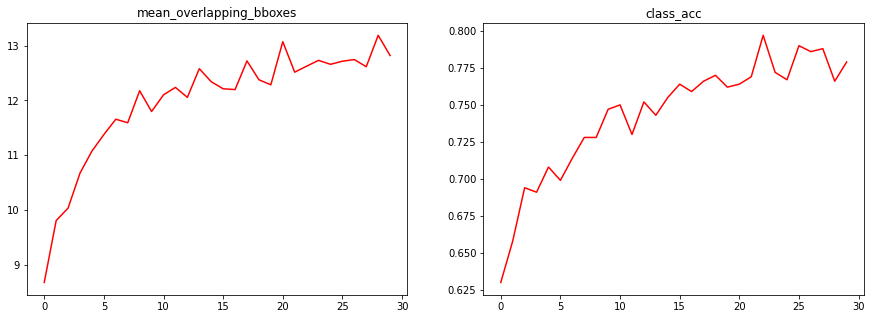

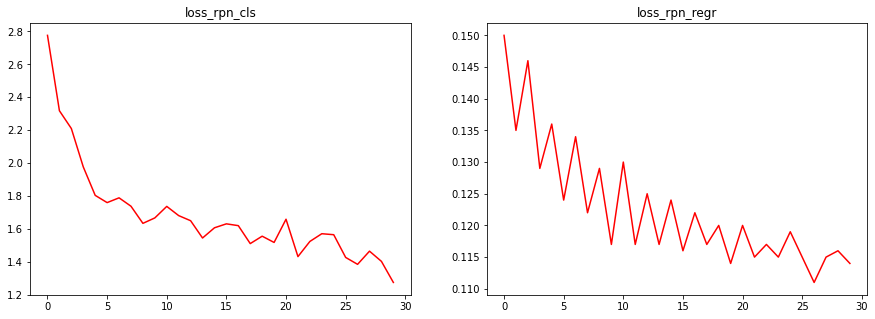

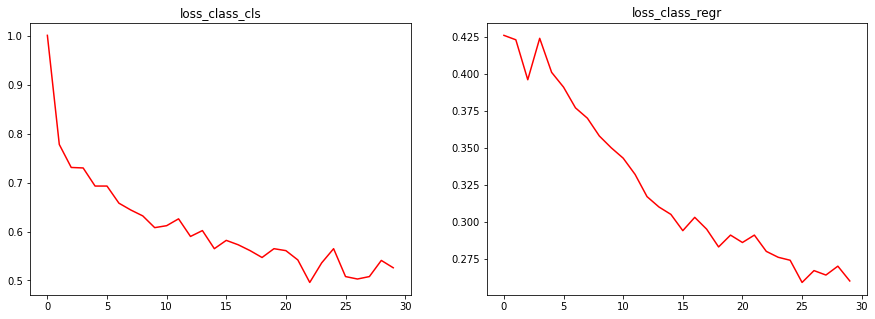

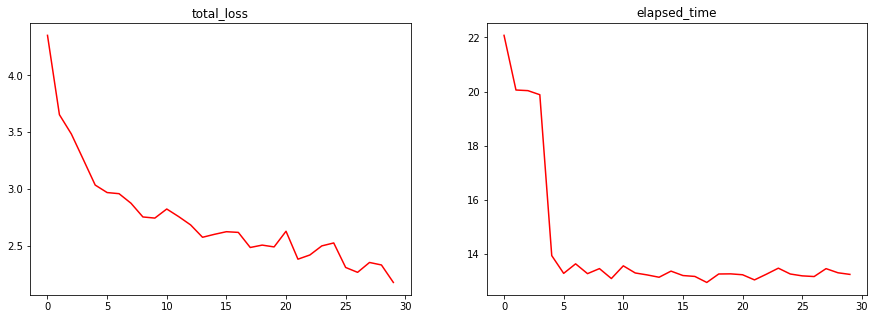

In [5]:
record_df = pd.read_csv(C.record_path)

r_epochs = len(record_df)

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(np.arange(0, r_epochs), record_df['mean_overlapping_bboxes'], 'r')
plt.title('mean_overlapping_bboxes')

plt.subplot(1,2,2)
plt.plot(np.arange(0, r_epochs), record_df['class_acc'], 'r')
plt.title('class_acc')

plt.show()

plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.plot(np.arange(0, r_epochs), record_df['loss_rpn_cls'], 'r')
plt.title('loss_rpn_cls')

plt.subplot(1,2,2)
plt.plot(np.arange(0, r_epochs), record_df['loss_rpn_regr'], 'r')
plt.title('loss_rpn_regr')
plt.show()
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(np.arange(0, r_epochs), record_df['loss_class_cls'], 'r')
plt.title('loss_class_cls')

plt.subplot(1,2,2)
plt.plot(np.arange(0, r_epochs), record_df['loss_class_regr'], 'r')
plt.title('loss_class_regr')
plt.show()
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(np.arange(0, r_epochs), record_df['curr_loss'], 'r')
plt.title('total_loss')

plt.subplot(1,2,2)
plt.plot(np.arange(0, r_epochs), record_df['elapsed_time'], 'r')
plt.title('elapsed_time')

plt.show()

015b7bbb49047448.jpg
Elapsed time = 4.284860849380493
[('Cat', 99.2274820804596)]


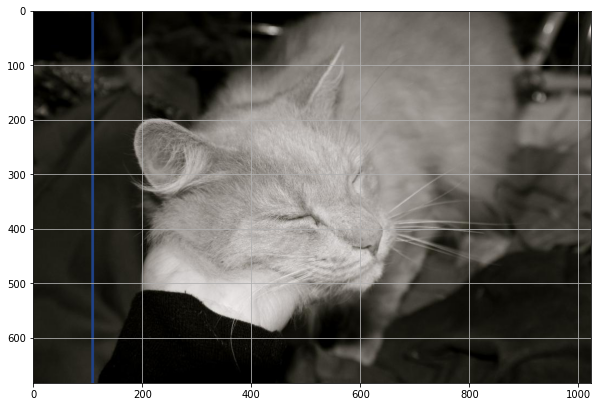

00c70af06636411f.jpg
Elapsed time = 1.4269442558288574
[]


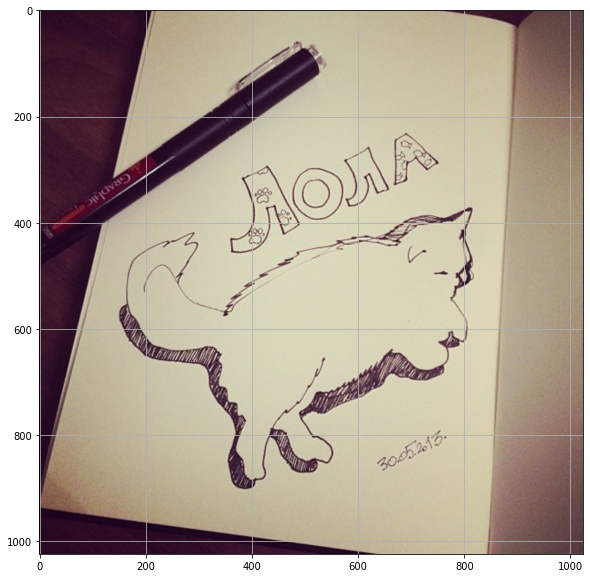

0ad4c67e75e17b67.jpg
Elapsed time = 1.39180326461792
[('Human face', 96.02821469306946), ('Human face', 90.55490493774414), ('Laptop', 79.96271252632141)]


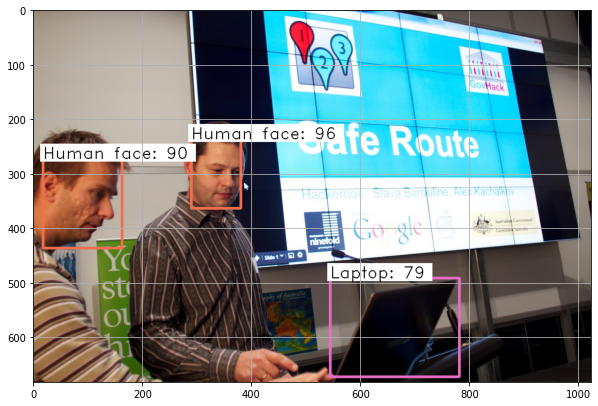

0b6b381cc2836ac7.jpg
Elapsed time = 1.7962145805358887
[('Mobile phone', 98.33002090454102), ('Human face', 82.84180164337158)]


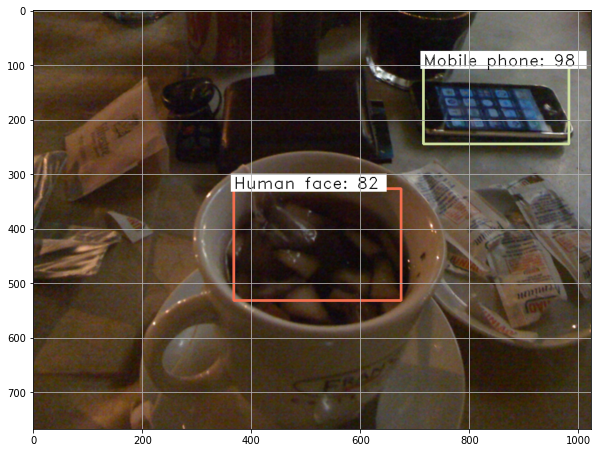

004aad5d1768160f.jpg
Elapsed time = 1.6596832275390625
[('Person', 77.72932648658752), ('Person', 76.36508345603943), ('Human face', 94.62262392044067), ('Human face', 93.27774047851562), ('Human face', 87.24654912948608), ('Human face', 79.79199886322021), ('Human face', 77.32664346694946)]


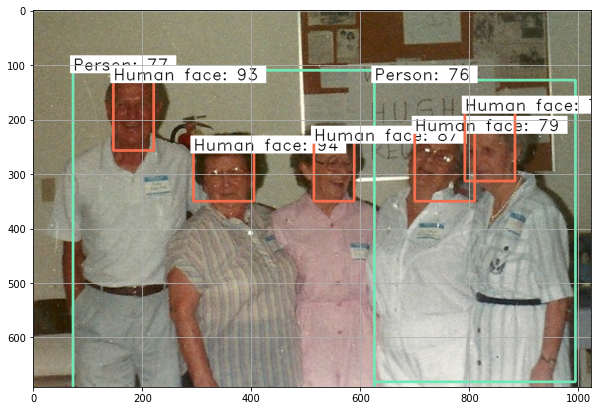

000243216b5a8e54.jpg
Elapsed time = 1.6591558456420898
[('Person', 91.70721173286438), ('Human face', 85.19304990768433), ('Human face', 80.94176650047302)]


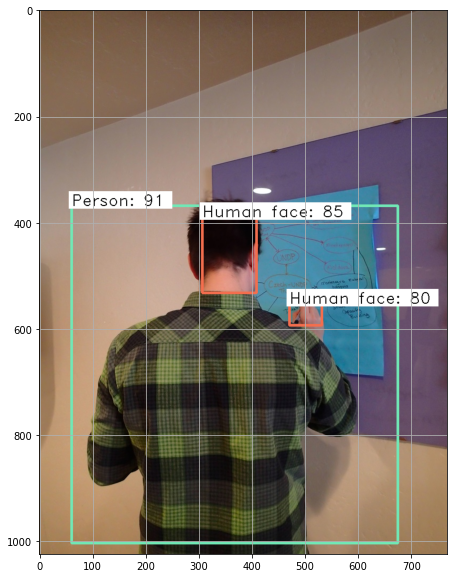

00124282a63ecb59.jpg
Elapsed time = 1.5567903518676758
[('Person', 89.38257098197937)]


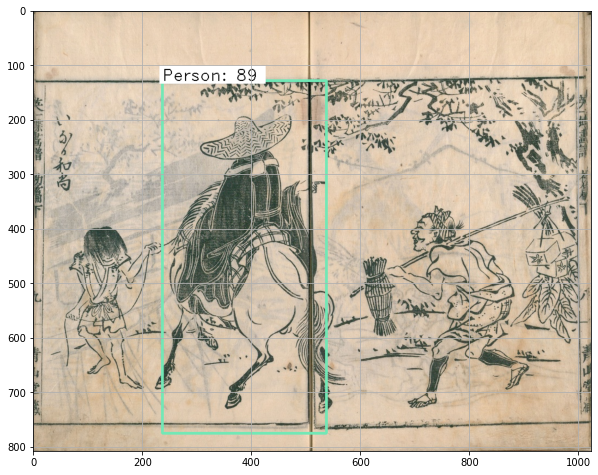

0024840807a64546.jpg
Elapsed time = 1.7587535381317139
[('Person', 75.00628232955933), ('Human face', 95.42254209518433)]


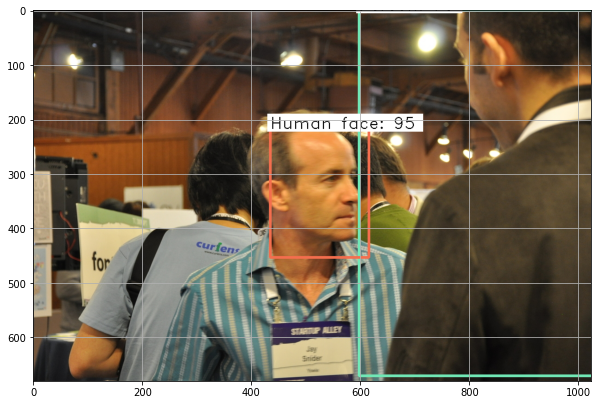

0ad257a80cc1c047.jpg
Elapsed time = 1.117689609527588
[('Mobile phone', 98.45767617225647), ('Mobile phone', 94.98984217643738)]


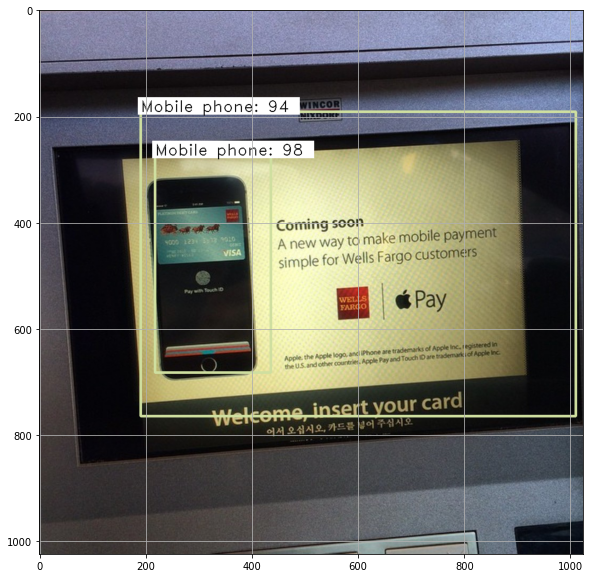

01d0818e97339657.jpg
Elapsed time = 1.433617115020752
[('Cat', 99.32936429977417)]


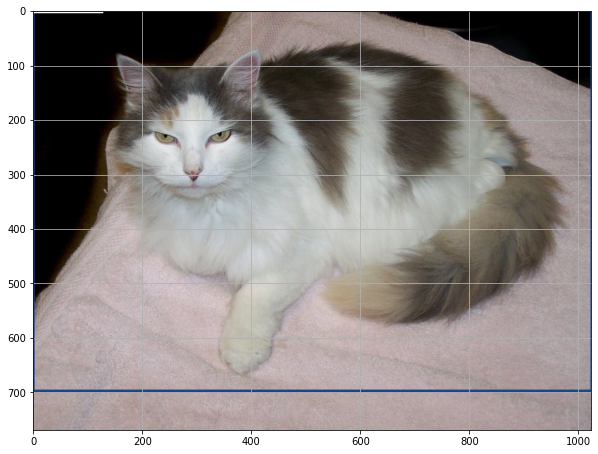

0f680fb34eda930d.jpg
Elapsed time = 1.4758532047271729
[('Laptop', 98.23724627494812), ('Laptop', 83.38177800178528)]


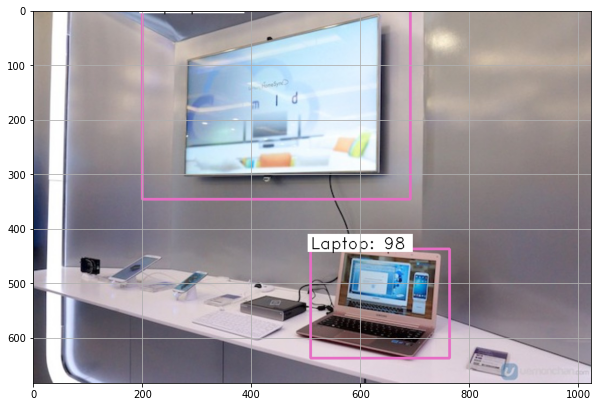

0434ea33f3f9999f.jpg
Elapsed time = 1.2785022258758545
[('Laptop', 99.08198714256287), ('Mobile phone', 77.3012638092041)]


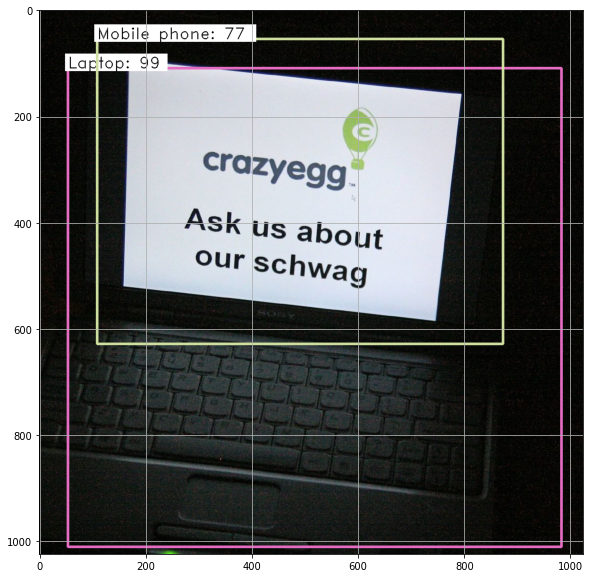

In [6]:
test_imgs = os.listdir(test_base_path)

imgs_path = []
for i in range(12):
	idx = np.random.randint(len(test_imgs))
	imgs_path.append(test_imgs[idx])

bbox_threshold = 0.7

for idx, img_name in enumerate(imgs_path):
    if not img_name.lower().endswith(('.bmp', '.jpeg', '.jpg', '.png', '.tif', '.tiff')):
        continue
    print(img_name)
    st = time.time()
    filepath = os.path.join(test_base_path, img_name)

    img = cv2.imread(filepath)

    X, ratio = format_img(img, C)
    
    X = np.transpose(X, (0, 2, 3, 1))

    [Y1, Y2, F] = model_rpn.predict(X)

    R = rpn_to_roi(Y1, Y2, C, None, overlap_thresh=0.7)

    R[:, 2] -= R[:, 0]
    R[:, 3] -= R[:, 1]

    bboxes = {}
    probs = {}

    for jk in range(R.shape[0]//C.num_rois + 1):
        ROIs = np.expand_dims(R[C.num_rois*jk:C.num_rois*(jk+1), :], axis=0)
        if ROIs.shape[1] == 0:
            break

        if jk == R.shape[0]//C.num_rois:
            
            curr_shape = ROIs.shape
            target_shape = (curr_shape[0],C.num_rois,curr_shape[2])
            ROIs_padded = np.zeros(target_shape).astype(ROIs.dtype)
            ROIs_padded[:, :curr_shape[1], :] = ROIs
            ROIs_padded[0, curr_shape[1]:, :] = ROIs[0, 0, :]
            ROIs = ROIs_padded

        [P_cls, P_regr] = model_classifier_only.predict([F, ROIs])

        for ii in range(P_cls.shape[1]):
            
            if np.max(P_cls[0, ii, :]) < bbox_threshold or np.argmax(P_cls[0, ii, :]) == (P_cls.shape[2] - 1):
                continue

            cls_name = class_mapping[np.argmax(P_cls[0, ii, :])]

            if cls_name not in bboxes:
                bboxes[cls_name] = []
                probs[cls_name] = []

            (x, y, w, h) = ROIs[0, ii, :]

            cls_num = np.argmax(P_cls[0, ii, :])
            try:
                (tx, ty, tw, th) = P_regr[0, ii, 4*cls_num:4*(cls_num+1)]
                tx /= C.classifier_regr_std[0]
                ty /= C.classifier_regr_std[1]
                tw /= C.classifier_regr_std[2]
                th /= C.classifier_regr_std[3]
                x, y, w, h = apply_regr(x, y, w, h, tx, ty, tw, th)
            except:
                pass
            bboxes[cls_name].append([C.rpn_stride*x, C.rpn_stride*y, C.rpn_stride*(x+w), C.rpn_stride*(y+h)])
            probs[cls_name].append(np.max(P_cls[0, ii, :]))

    all_dets = []

    for key in bboxes:
        bbox = np.array(bboxes[key])

        new_boxes, new_probs = non_max_suppression_fast(bbox, np.array(probs[key]), overlap_thresh=0.2)
        for jk in range(new_boxes.shape[0]):
            (x1, y1, x2, y2) = new_boxes[jk,:]

            (real_x1, real_y1, real_x2, real_y2) = get_real_coordinates(ratio, x1, y1, x2, y2)

            cv2.rectangle(img,(real_x1, real_y1), (real_x2, real_y2), (int(class_to_color[key][0]), int(class_to_color[key][1]), int(class_to_color[key][2])),4)

            textLabel = '{}: {}'.format(key,int(100*new_probs[jk]))
            all_dets.append((key,100*new_probs[jk]))

            (retval,baseLine) = cv2.getTextSize(textLabel,cv2.FONT_HERSHEY_COMPLEX,1,1)
            textOrg = (real_x1, real_y1-0)

            cv2.rectangle(img, (textOrg[0] - 5, textOrg[1]+baseLine - 5), (textOrg[0]+retval[0] + 5, textOrg[1]-retval[1] - 5), (0, 0, 0), 1)
            cv2.rectangle(img, (textOrg[0] - 5,textOrg[1]+baseLine - 5), (textOrg[0]+retval[0] + 5, textOrg[1]-retval[1] - 5), (255, 255, 255), -1)
            cv2.putText(img, textLabel, textOrg, cv2.FONT_HERSHEY_DUPLEX, 1, (0, 0, 0), 1)

    print('Elapsed time = {}'.format(time.time() - st))
    print(all_dets)
    plt.figure(figsize=(10,10))
    plt.grid()
    plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
    plt.show()